In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [5]:
# Extract sentences and labels
def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])
        labels.append(item['ner_tags'])
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

# Ensure labels are integers (handles string labels if present)
train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Download and load GloVe embeddings
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url)
    with open("glove.6B.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
        zip_ref.extractall()

# Load GloVe vectors
glove_model = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_model[word] = vector

# Build vocabulary and embeddings matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))

In [6]:
# Prepare input sequences and pad
MAX_LEN = 512
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [7]:
torch.set_float32_matmul_precision("high")

In [8]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x



In [9]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

import torch.nn.functional as F

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        accuracies = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            mask = (y != 0)
            correct = (preds == y) & mask
            accuracy = correct.sum().item() / mask.sum().item()
            accuracies[k] = accuracy
        
        out[name] = {
            "loss": losses.mean().item(),
            "accuracy": accuracies.mean().item()
        }
    model.train()
    return out

In [19]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_model(model, optimizer): 
    model.to(device)
    max_iters = 2000
    eval_interval = 200
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    eval_steps = []

    lossi = []

    for step in range(max_iters):
        if step % eval_interval == 0:
            metrics = estimate_loss(model)
            
            train_losses.append(metrics['train']['loss'])
            test_losses.append(metrics['test']['loss'])
            train_accuracies.append(metrics['train']['accuracy'])
            test_accuracies.append(metrics['test']['accuracy'])
            eval_steps.append(step)

            print(
                f"Step {step}: "
                f"Train loss {metrics['train']['loss']:.4f}, accuracy {metrics['train']['accuracy']:.4f} | "
                f"Test loss {metrics['test']['loss']:.4f}, accuracy {metrics['test']['accuracy']:.4f}"
            )
        
        xb, yb = get_batch(train_dataset, batch_size)
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
        
        lossi.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_steps, train_losses, label="Train Loss")
    plt.plot(eval_steps, test_losses, label="Test Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, train_accuracies, label="Train Accuracy")
    plt.plot(eval_steps, test_accuracies, label="Test Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [20]:
def evaluate_model(model):
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()
    
    true_labels = y_test.cpu().numpy()
    
    # Format for evaluation
    true_str = []
    pred_str = []
    for t_seq, p_seq in zip(true_labels, pred_labels):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != 0:
                temp_true.append(labels[t])
                temp_pred.append(labels[p])
        true_str.append(temp_true)
        pred_str.append(temp_pred)
    
    # Detailed evaluation report
    print("Classification Report:\n")
    print(classification_report(true_str, pred_str))
    print("F1 Score:", f1_score(true_str, pred_str))
    print("Accuracy:", accuracy_score(true_str, pred_str))

Step 0: Train loss 1.3676, accuracy 0.3689 | Test loss 1.3654, accuracy 0.4143
Step 200: Train loss 0.7017, accuracy 0.7334 | Test loss 0.6986, accuracy 0.7202
Step 400: Train loss 0.3872, accuracy 0.8710 | Test loss 0.4126, accuracy 0.8639
Step 600: Train loss 0.2806, accuracy 0.9091 | Test loss 0.3232, accuracy 0.8814
Step 800: Train loss 0.2469, accuracy 0.9081 | Test loss 0.2657, accuracy 0.9051
Step 1000: Train loss 0.2162, accuracy 0.9245 | Test loss 0.3009, accuracy 0.8859
Step 1200: Train loss 0.1685, accuracy 0.9429 | Test loss 0.2891, accuracy 0.8877
Step 1400: Train loss 0.1763, accuracy 0.9390 | Test loss 0.2988, accuracy 0.8913
Step 1600: Train loss 0.1291, accuracy 0.9625 | Test loss 0.2424, accuracy 0.9151
Step 1800: Train loss 0.1262, accuracy 0.9619 | Test loss 0.2698, accuracy 0.9053


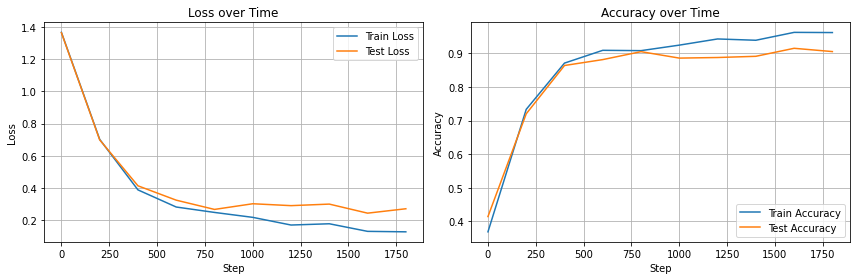

Classification Report:

              precision    recall  f1-score   support

          AC       0.92      0.92      0.92       797
          LF       0.75      0.86      0.80       482

   micro avg       0.85      0.90      0.87      1279
   macro avg       0.84      0.89      0.86      1279
weighted avg       0.86      0.90      0.88      1279

F1 Score: 0.8732394366197183
Accuracy: 0.9118116520351157


In [21]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3901, accuracy 0.2311 | Test loss 1.3839, accuracy 0.2160
Step 200: Train loss 1.3003, accuracy 0.5133 | Test loss 1.2958, accuracy 0.5069
Step 400: Train loss 1.2065, accuracy 0.4716 | Test loss 1.2039, accuracy 0.4790
Step 600: Train loss 1.0885, accuracy 0.4861 | Test loss 1.0871, accuracy 0.4817
Step 800: Train loss 0.9896, accuracy 0.5080 | Test loss 0.9951, accuracy 0.5613
Step 1000: Train loss 0.9322, accuracy 0.5984 | Test loss 0.9378, accuracy 0.6166
Step 1200: Train loss 0.8897, accuracy 0.6514 | Test loss 0.9046, accuracy 0.6234
Step 1400: Train loss 0.8447, accuracy 0.6718 | Test loss 0.8443, accuracy 0.6614
Step 1600: Train loss 0.7934, accuracy 0.6977 | Test loss 0.8137, accuracy 0.6657
Step 1800: Train loss 0.7351, accuracy 0.7146 | Test loss 0.7484, accuracy 0.6882


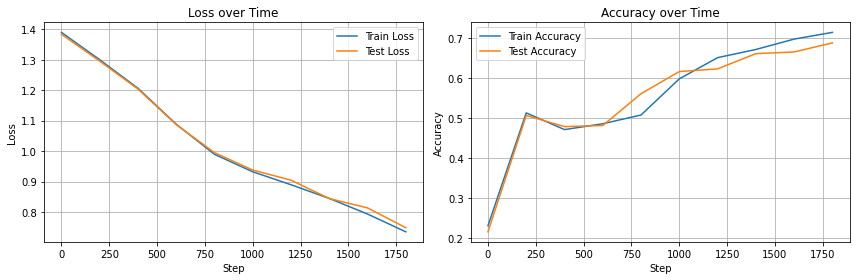

Classification Report:

              precision    recall  f1-score   support

          AC       0.69      0.87      0.77       797
          LF       0.49      0.57      0.53       482

   micro avg       0.62      0.76      0.68      1279
   macro avg       0.59      0.72      0.65      1279
weighted avg       0.61      0.76      0.68      1279

F1 Score: 0.6799859796705222
Accuracy: 0.7190742218675179


In [22]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3661, accuracy 0.4220 | Test loss 1.3665, accuracy 0.4192
Step 200: Train loss 0.1576, accuracy 0.9459 | Test loss 0.2280, accuracy 0.9159
Step 400: Train loss 0.0648, accuracy 0.9808 | Test loss 0.2530, accuracy 0.9139
Step 600: Train loss 0.0131, accuracy 0.9972 | Test loss 0.2383, accuracy 0.9329
Step 800: Train loss 0.0052, accuracy 0.9997 | Test loss 0.2892, accuracy 0.9191
Step 1000: Train loss 0.0034, accuracy 0.9994 | Test loss 0.3089, accuracy 0.9213
Step 1200: Train loss 0.0012, accuracy 1.0000 | Test loss 0.3178, accuracy 0.9292
Step 1400: Train loss 0.0004, accuracy 1.0000 | Test loss 0.2913, accuracy 0.9300
Step 1600: Train loss 0.0004, accuracy 1.0000 | Test loss 0.3993, accuracy 0.9134
Step 1800: Train loss 0.0003, accuracy 1.0000 | Test loss 0.3498, accuracy 0.9242


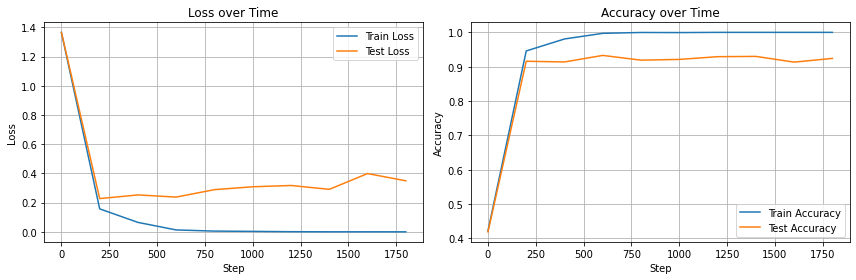

Classification Report:

              precision    recall  f1-score   support

          AC       0.91      0.96      0.93       797
          LF       0.76      0.84      0.80       482

   micro avg       0.85      0.91      0.88      1279
   macro avg       0.83      0.90      0.86      1279
weighted avg       0.85      0.91      0.88      1279

F1 Score: 0.8808446455505279
Accuracy: 0.9201915403032721


In [25]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3749, accuracy 0.2943 | Test loss 1.3721, accuracy 0.3317
Step 200: Train loss 0.5398, accuracy 0.8108 | Test loss 0.5734, accuracy 0.7822
Step 400: Train loss 0.3772, accuracy 0.8746 | Test loss 0.4156, accuracy 0.8579
Step 600: Train loss 0.3182, accuracy 0.8975 | Test loss 0.3676, accuracy 0.8722
Step 800: Train loss 0.3015, accuracy 0.8900 | Test loss 0.3281, accuracy 0.8808
Step 1000: Train loss 0.2570, accuracy 0.9149 | Test loss 0.3250, accuracy 0.8854
Step 1200: Train loss 0.2312, accuracy 0.9234 | Test loss 0.3180, accuracy 0.8798
Step 1400: Train loss 0.2079, accuracy 0.9318 | Test loss 0.2562, accuracy 0.9050
Step 1600: Train loss 0.2202, accuracy 0.9251 | Test loss 0.2668, accuracy 0.9025
Step 1800: Train loss 0.2129, accuracy 0.9245 | Test loss 0.2737, accuracy 0.8974


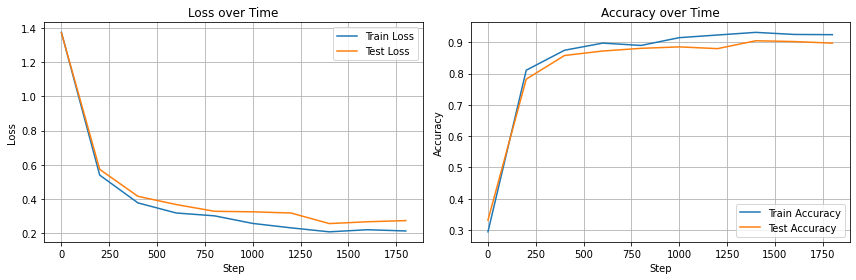

Classification Report:

              precision    recall  f1-score   support

          AC       0.91      0.93      0.92       797
          LF       0.71      0.84      0.77       482

   micro avg       0.83      0.89      0.86      1279
   macro avg       0.81      0.88      0.85      1279
weighted avg       0.84      0.89      0.86      1279

F1 Score: 0.8620949510173322
Accuracy: 0.907023144453312


In [26]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)